RK4 - Radius: 14.43 km, Mass: 2.542 M_sun
Maximum Mass: 2.666 M_sun at Radius: 13.78 km


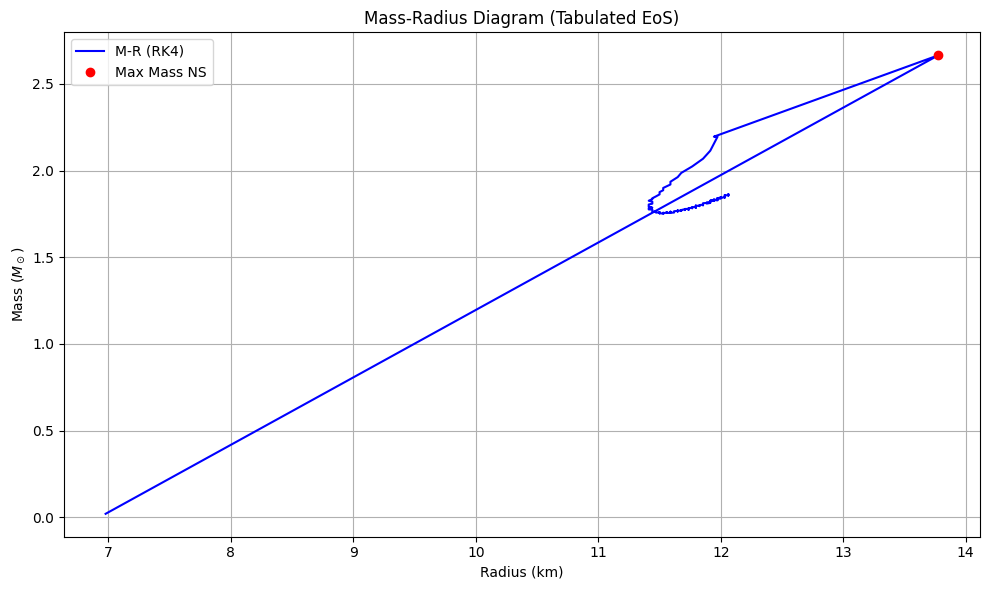

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Constants
Len_conv = 1.476701332464468e+05  # Length conversion factor

# Load EoS data from file
def load_eos(filename='EOSSamma_2_6_04.dat', scale=1.3152e-6):
    rho, p = np.loadtxt(filename, unpack=True)
    rho *= scale
    p *= scale
    # Compute energy density using first-law relation: e = rho + p/(Gamma-1) [not used here]
    return rho, p

rho_data, p_data = load_eos()

# Create interpolation functions
pres_to_edens = interp1d(p_data, rho_data, kind='linear', bounds_error=False, fill_value='extrapolate')
edens_to_pres = interp1d(rho_data, p_data, kind='linear', bounds_error=False, fill_value='extrapolate')

# TOV equations
def TOV(t, y):
    r = t
    m = y[0]  # mass
    p = y[1]  # pressure
    ene = pres_to_edens(p)
    if np.isnan(ene) or r == 0:
        return np.array([0, 0])
    dy = np.empty_like(y)
    dy[0] = 4 * np.pi * ene * r**2
    dy[1] = - (ene + p) * (m + 4 * np.pi * r**3 * p) / (r * (r - 2 * m))
    return dy

def found_radius(t, y, pmin=0):
    return (y[1] - pmin) <= 0

def set_initial_conditions(rho, rmin):
    p = edens_to_pres(rho)
    m = 4/3 * np.pi * rho * rmin**3
    return m, p

# ODE solvers
def solve_ode_rk4(t, y0, dydt_fun, stop_iter=None, ver=False):
    N = len(t)
    dt = np.diff(t)[0]
    y = y0
    for i in range(N):
        yprev = np.copy(y)
        k1 = dydt_fun(t[i], y)
        k2 = dydt_fun(t[i] + dt/2, y + dt/2 * k1)
        k3 = dydt_fun(t[i] + dt/2, y + dt/2 * k2)
        k4 = dydt_fun(t[i] + dt, y + dt * k3)
        y += (k1 + 2*k2 + 2*k3 + k4) * dt / 6
        if ver: print(t[i], y)
        if stop_iter and stop_iter(t[i], y):
            return t[i-1], yprev
    return t[i], y

# Parameters
rmin, rmax = 1e-6, 20.0
N = 1000
rrange = np.linspace(rmin, rmax, N)

# Central density
rho0 = 1.3e-3
p0 = edens_to_pres(rho0)
m0 = 4/3 * np.pi * rho0 * rmin**3
sol0 = [m0, p0]

# Solve for single configuration
t_rk4, sol_rk4 = solve_ode_rk4(rrange, sol0, TOV, stop_iter=found_radius)
R_rk4 = t_rk4 * Len_conv * 1e-5
M_rk4 = sol_rk4[0]
print(f"RK4 - Radius: {R_rk4:.2f} km, Mass: {M_rk4:.3f} M_sun")

# Build mass-radius sequence
rhorange = np.linspace(rho_data.min(), rho_data.max(), 200)
R_seq = []
M_seq = []

for rho0 in rhorange:
    sol0 = set_initial_conditions(rho0, rmin)
    t_rk4, sol_rk4 = solve_ode_rk4(rrange, sol0, TOV, stop_iter=found_radius)
    R_seq.append(t_rk4)
    M_seq.append(sol_rk4[0])

R_seq = np.array(R_seq)
M_seq = np.array(M_seq)
imax = np.argmax(M_seq)
Mmax = M_seq[imax]
Rmax = R_seq[imax]
print(f"Maximum Mass: {Mmax:.3f} M_sun at Radius: {Rmax * Len_conv * 1e-5:.2f} km")

# Plot Mass-Radius diagram
km = Len_conv * 1e-5
plt.figure(figsize=(10, 6))
plt.plot(R_seq * km, M_seq, 'b-', label='M-R (RK4)')
plt.plot(Rmax * km, Mmax, 'ro', label='Max Mass NS')
plt.xlabel('Radius (km)')
plt.ylabel('Mass ($M_\\odot$)')
plt.title('Mass-Radius Diagram (Tabulated EoS)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('TOV_MR_EOS_from_file.png')
plt.show()
